In [9]:
import os.path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torchvision import transforms
from tqdm import tqdm

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, self.bilinear)
        self.up2 = Up(512, 256 // factor, self.bilinear)
        self.up3 = Up(256, 128 // factor, self.bilinear)
        self.up4 = Up(128, 64, self.bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img)))
])

class SemSegDS(torch.utils.data.Dataset):
    def __init__(self, root, split, transform, target_transform):
        from PIL import Image
        self.root = root
        self.path = os.path.join(self.root, 'sem-seg')
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.img_dir = os.path.join(os.path.expanduser(self.path), split, 'img')
        self.mask_dir = os.path.join(os.path.expanduser(self.path), split, 'label')
        self.imgs = [transform(Image.open(os.path.join(self.img_dir, f))) for f in sorted(os.listdir(self.img_dir))]
        self.masks = [target_transform(
            Image.open(os.path.join(self.mask_dir, f)).convert('L')
        ) for f in sorted(os.listdir(self.mask_dir))]

    def __getitem__(self, index):
        return self.imgs[index], self.masks[index]

    def __len__(self):
        return len(self.imgs)

train_ds = SemSegDS('~/data', 'train', transform, target_transform)
test_ds = SemSegDS('~/data', 'val', transform, target_transform)

torch.Size([96, 256])


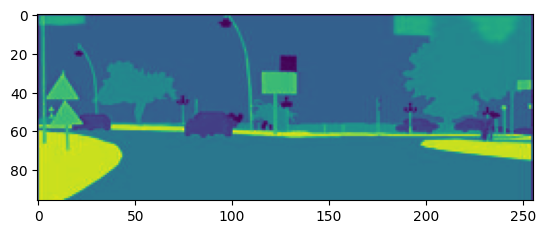

In [13]:
import matplotlib.pyplot as plt

for _, label in train_ds:
    print(label.shape)
    plt.imshow(label)
    break

In [14]:
from pandas import Series

ctx = Series()

ctx.batch_size = 8

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=ctx.batch_size, shuffle=True
)
test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=ctx.batch_size, shuffle=False
)

In [15]:
ctx.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ctx.epochs = 32

model = UNet(n_channels=3, n_classes=256, bilinear=True).to(ctx.device)

criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore void class (255)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

ctx.saved_w = 'unet.pt'

if os.path.isfile(ctx.saved_w):
    model.load_state_dict(
        torch.load(ctx.saved_w, weights_only=True)
    )

avg_loss: 3.937:   0%|          | 0/32 [00:43<?, ?it/s, 372 / 372 loss: 3.5810]

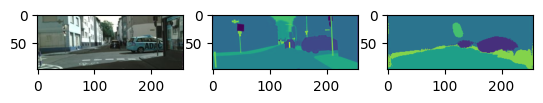

avg_loss: 2.917:   3%|▎         | 1/32 [01:27<22:46, 44.07s/it, 372 / 372 loss: 2.7233]

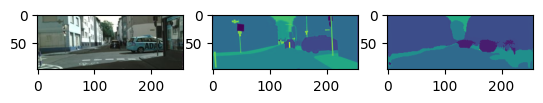

avg_loss: 2.545:   6%|▋         | 2/32 [02:11<21:48, 43.63s/it, 372 / 372 loss: 2.5320]

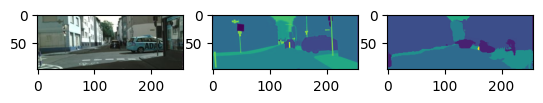

avg_loss: 2.384:   9%|▉         | 3/32 [02:55<21:08, 43.73s/it, 372 / 372 loss: 2.2005]

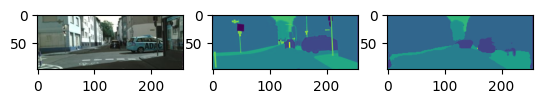

avg_loss: 2.282:  12%|█▎        | 4/32 [03:38<20:27, 43.83s/it, 372 / 372 loss: 1.9964]

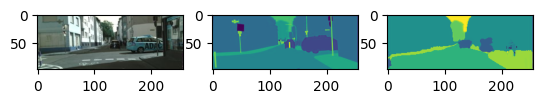

avg_loss: 2.217:  16%|█▌        | 5/32 [04:23<19:45, 43.89s/it, 372 / 372 loss: 2.2000]

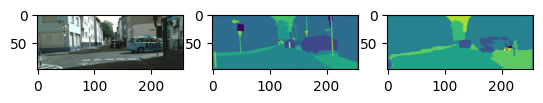

avg_loss: 2.156:  19%|█▉        | 6/32 [05:07<19:05, 44.05s/it, 372 / 372 loss: 2.3333]

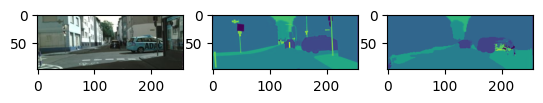

avg_loss: 2.110:  22%|██▏       | 7/32 [05:51<18:21, 44.04s/it, 372 / 372 loss: 1.8349]

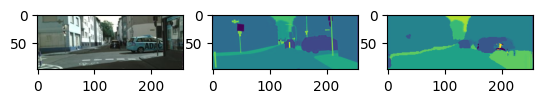

avg_loss: 2.071:  25%|██▌       | 8/32 [06:35<17:35, 43.99s/it, 372 / 372 loss: 2.1623]

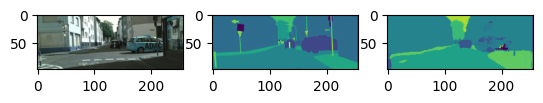

avg_loss: 2.036:  28%|██▊       | 9/32 [07:19<16:50, 43.95s/it, 372 / 372 loss: 2.0591]

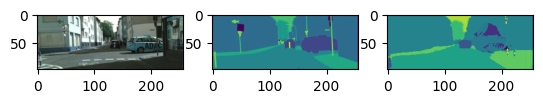

avg_loss: 2.002:  31%|███▏      | 10/32 [08:03<16:09, 44.07s/it, 372 / 372 loss: 1.9638]

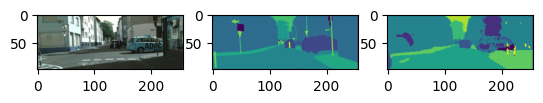

avg_loss: 1.968:  34%|███▍      | 11/32 [08:47<15:26, 44.10s/it, 372 / 372 loss: 1.9260]

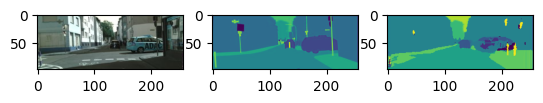

avg_loss: 1.941:  38%|███▊      | 12/32 [09:32<14:42, 44.10s/it, 372 / 372 loss: 1.7701]

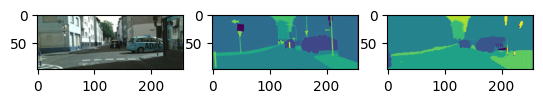

avg_loss: 1.918:  41%|████      | 13/32 [10:16<14:00, 44.21s/it, 372 / 372 loss: 2.0079]

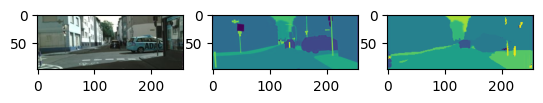

avg_loss: 1.896:  44%|████▍     | 14/32 [11:02<13:14, 44.16s/it, 372 / 372 loss: 1.9326]

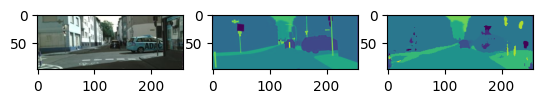

avg_loss: 1.868:  47%|████▋     | 15/32 [11:46<12:41, 44.77s/it, 372 / 372 loss: 1.8764]

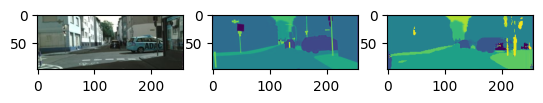

avg_loss: 1.852:  50%|█████     | 16/32 [12:30<11:52, 44.51s/it, 372 / 372 loss: 1.9795]

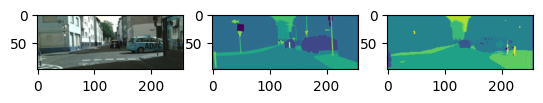

avg_loss: 1.828:  53%|█████▎    | 17/32 [13:15<11:07, 44.52s/it, 372 / 372 loss: 2.0421]

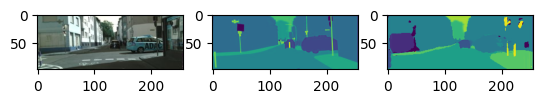

avg_loss: 1.808:  56%|█████▋    | 18/32 [14:00<10:24, 44.61s/it, 372 / 372 loss: 1.7272]

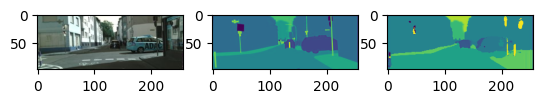

avg_loss: 1.784:  59%|█████▉    | 19/32 [14:45<09:40, 44.69s/it, 372 / 372 loss: 1.9311]

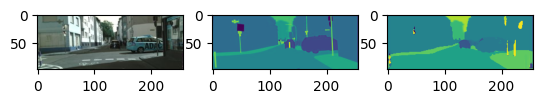

avg_loss: 1.767:  62%|██████▎   | 20/32 [15:29<08:55, 44.67s/it, 372 / 372 loss: 1.7544]

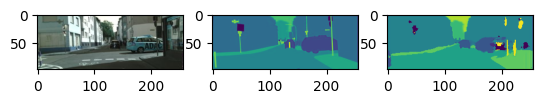

avg_loss: 1.750:  66%|██████▌   | 21/32 [16:13<08:09, 44.48s/it, 372 / 372 loss: 1.6740]

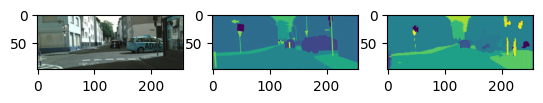

avg_loss: 1.731:  69%|██████▉   | 22/32 [16:57<07:25, 44.54s/it, 372 / 372 loss: 1.6573]

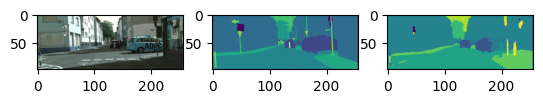

avg_loss: 1.715:  72%|███████▏  | 23/32 [17:41<06:39, 44.35s/it, 372 / 372 loss: 1.8566]

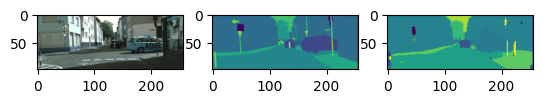

avg_loss: 1.702:  75%|███████▌  | 24/32 [18:25<05:53, 44.16s/it, 372 / 372 loss: 1.6342]

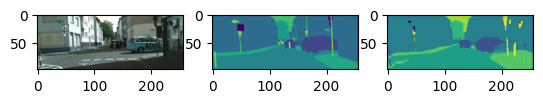

avg_loss: 1.687:  78%|███████▊  | 25/32 [19:08<05:07, 43.96s/it, 372 / 372 loss: 1.7255]

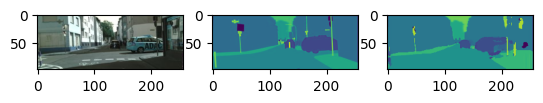

avg_loss: 1.694:  81%|████████▏ | 26/32 [19:52<04:23, 43.89s/it, 372 / 372 loss: 2.0076]

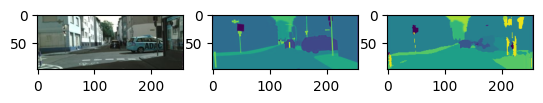

avg_loss: 1.678:  84%|████████▍ | 27/32 [20:35<03:38, 43.76s/it, 372 / 372 loss: 1.6986]

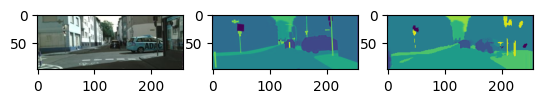

avg_loss: 1.646:  88%|████████▊ | 28/32 [21:22<02:55, 43.80s/it, 372 / 372 loss: 1.8786]

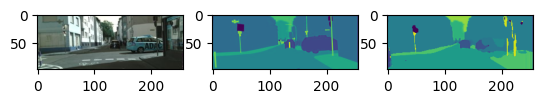

avg_loss: 1.637:  91%|█████████ | 29/32 [22:09<02:13, 44.53s/it, 372 / 372 loss: 1.7216]

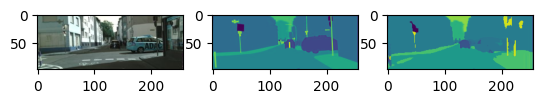

avg_loss: 1.622:  94%|█████████▍| 30/32 [22:57<01:30, 45.43s/it, 372 / 372 loss: 1.6143]

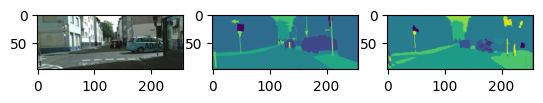

avg_loss: 1.617:  97%|█████████▋| 31/32 [23:45<00:46, 46.21s/it, 372 / 372 loss: 1.5031]

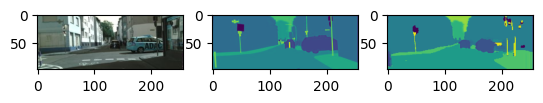

avg_loss: 1.617: 100%|██████████| 32/32 [23:45<00:00, 44.56s/it, 372 / 372 loss: 1.5031]


In [16]:
pbar = tqdm(range(1, 1 + ctx.epochs))

len_tr_dl = len(train_dl)

plt.ion()
for epoch in pbar:
    avg_loss = 0
    for idx, (images, targets) in enumerate(train_dl):
        images = images.to(ctx.device)
        targets = targets.to(ctx.device)

        optimizer.zero_grad()
        outputs = model(images)

        outputs = rearrange(outputs, 'b l h w -> (b h w) l')
        targets = rearrange(targets, 'b h w -> (b h w)')

        loss = criterion(outputs, targets.long())
        avg_loss += loss.item() / len_tr_dl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f'{idx + 1} / {len_tr_dl} loss: {loss.item():.4f}')
    pbar.set_description_str(f'avg_loss: {avg_loss:.3f}')
    fig, axes = plt.subplots(1, 3)
    for image, target in test_ds:
        axes[0].clear()
        axes[0].imshow(rearrange(image, 'c h w -> h w c'))
        torch.save(model.state_dict(), ctx.saved_w)
        model.eval()
        pred = model(image.to(ctx.device).unsqueeze(dim=0)).squeeze(dim=0)
        axes[1].clear()
        axes[1].imshow(target)
        pred = rearrange(pred, 'l h w -> h w l').argmax(dim=-1)
        axes[2].clear()
        axes[2].imshow(pred.cpu().detach().numpy())
        plt.pause(0.001)
        plt.show()
        model.train()
        break
